# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Напишите заголовок первой части проекта здесь

- Автор: Чернышова О.В.
- Дата: 28.01.2026г.

## Цели и задачи проекта

<font color='#777778'>
    
    1. Проверка в Python гипотезы: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.
    
    2. Анализ результатов A/B-тестирования. Гипотеза заключается в следующем: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта..</font>

## Описание данных

<font color='#777778'>

    
    
    
   
 	 
Поля таблиц syandex_knigi_data.csv:

    Unnamed - порядковый номер
    
    city - город
    
    puid — идентификатор пользователя

    hours — часы и чтения и прослушивания;
    
    
Поля таблиц ab_test_participants.csv:  
    
    user_id - идентификатор пользователя
    
    group - группа пользователя: контрольная(А) или тестовая (B)
    
    ab_test - название теста
    
    device - устройство, с которого происходила регистрация
    
Поля таблиц ab_test_events.zip:
    
    user_id - идентификатор пользователя	
    
    event_dt - дата и время события;
    
    event_name - вид события
    
    details - дополнительные данные о событии
</font>

## Содержимое проекта

<font color='#777778'>
  
    Раздел 1
    
    1. Загрузка данных и знакомство с ними
    
    2. Проверка на отсутствие пересечений пользователей по городам
    
    2. Исключение пересечений
    
    3. Распределение пользователей по городам
    
    4. Визуализация распределения размеров групп
    
    5. Проверка гипотезы в Python
    
    6. Аналитическая записка
    
    Раздел 2
    
    1. Загрузка данных и знакомство с ними
    
    2. По таблице ... проверка проведения теста в соответствие с ТЗ
    
    3. Проверка равномерность распределения пользователей по группам теста
    
    4. Проверка на отсутствие пересечений с конкурирующим тестом (нет пользователей
    
    участвующих одновременно в двух тестовых группах
    
    5. Анализ данные о пользовательской активности по таблице ...
    
    6. Отбор событий, связанных с участвующими в изучаемом тесте пользователями
    
    7. Определение горизонт анализа: рассчитать время (лайфтайм) совершения события пользователем после регистрации, 
    отбор событий, которые были выполнены в течение первых семи дней с момента регистрации
    
    8. Оценка достаточности выборки для получения статистически значимых результатов A/B-теста
    
    9. Рассчет для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей
    
    10. Оценка результатов A/B-тестирования.
    
    11. Вывод  
   </font>

---

## 1. Загрузка данных и знакомство с ними



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from datetime import timedelta
from statsmodels.stats.power import TTestIndPower
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower

In [3]:
yandex_knigi.head() 

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Выводим информацию о датафрейме вместе с пропусками
yandex_knigi.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [5]:
# Разделяем данные по городам и подсчитываем уникальные идентификаторы пользователей в каждом городе
puid_by_city = yandex_knigi.groupby('city')['puid'].nunique()
print("Уникальные puid по городам:")
print(puid_by_city) 

Уникальные puid по городам:
city
Москва             6234
Санкт-Петербург    2550
Name: puid, dtype: int64


In [6]:
# Разделяем данные по городам и подсчитываем долю пользователей в каждом городе

100 * yandex_knigi[yandex_knigi['city'] == 'Москва']['puid'].nunique() / yandex_knigi['puid'].nunique(), 100 * yandex_knigi[yandex_knigi['city'] == 'Санкт-Петербург']['puid'].nunique() / yandex_knigi['puid'].nunique() 

(72.9976580796253, 29.859484777517565)

In [7]:
# пользователи участвующие в каждом городе
m = yandex_knigi[yandex_knigi['city'] == 'Москва']['puid']
spb = yandex_knigi[yandex_knigi['city'] == 'Санкт-Петербург']['puid']

intersect = list(set(m) & set(spb))
print(intersect)

[439054848, 98068993, 84978689, 331188228, 59679749, 790564870, 40698887, 162106378, 1078819852, 1684058125, 1130000018954257, 959563282, 571554323, 1358054932, 313990163, 1778617878, 1210363415, 1316543509, 649885721, 1183963675, 1395494429, 1314529823, 1145886241, 1593760291, 1725564965, 24138278, 520518182, 363351088, 108083761, 570189363, 584447544, 860187201, 309104707, 550835780, 441112643, 1977784899, 1406501962, 528250442, 103543372, 1616171597, 589188176, 989693522, 1958805587, 401065555, 1557916755, 429727314, 1130000028554332, 488154206, 1965288031, 10597984, 9979490, 301108324, 1607495785, 767485035, 453988975, 912829040, 955554416, 1672056947, 819309176, 10815097, 196683896, 1076879993, 1974615673, 531369086, 1011254911, 555866239, 258809476, 66998918, 360290950, 1085783174, 236601993, 359740041, 998045836, 888840333, 2019864206, 1109631631, 1713008273, 317826707, 1236880533, 46837910, 1166679702, 137198745, 1891219106, 987817124, 1735154341, 176447657, 1748029097, 3793466

In [8]:
# исключаем пользователей, участвующих в каждом городе
df = yandex_knigi[~yandex_knigi['puid'].isin(intersect)] 

Размеры групп по городам:
city
Москва             5990
Санкт-Петербург    2306
dtype: int64


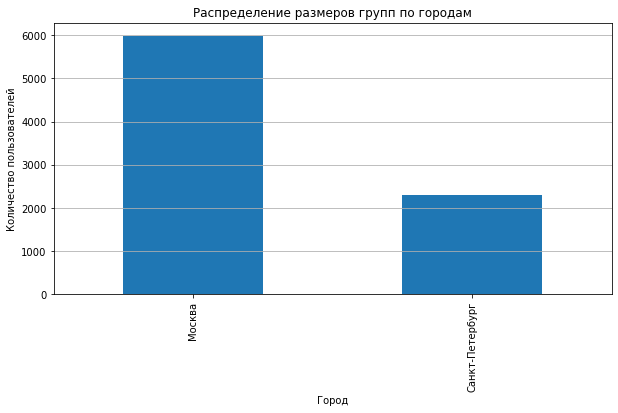

In [9]:
# Группируем данные по городу и подсчитываем количество пользователей в каждом городе
group_sizes = df.groupby('city').size()

# Выводим размеры групп
print("Размеры групп по городам:")
print(group_sizes)

# Визуализация распределения размеров групп

plt.figure(figsize=(10, 5))
group_sizes.plot(kind='bar')
plt.title('Распределение размеров групп по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.show()
 

## 2. Проверка гипотезы в Python



In [10]:
# Группируем данные по пользователю и суммируем время
grouped_by_user = df.groupby('puid')['hours'].sum().reset_index()

# Добавляем информацию о городе к суммарным данным
df_with_sum = pd.merge(grouped_by_user, df[['puid', 'city']].drop_duplicates(), on='puid')

# Выборка средних часов за чтением и прослушиванием книг в приложении пользователей для группы А
sample_a = df_with_sum[df_with_sum['city']=='Москва']['hours']
# Выборка средних часов за чтением и прослушиванием книг в приложении пользователей для группы B
sample_b = df_with_sum[df_with_sum['city']=='Санкт-Петербург']['hours']

test_result = ttest_ind(
    sample_a,
    sample_b,
    alternative='less' # Альтернативная гипотеза, которую проверяем: mu_a < mu_b
)

# Фиксируем уровень значимости
alpha = 0.05

if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу') 


pvalue=0.3264137070357819 > 0.05
Не получилось отвергнуть нулевую гипотезу


## 3. Аналитическая записка


Выбранный тип t-теста и уровень статистической значимости:

Был выбран односторонний t-тест для независимых выборок (ttest_ind).

Уровень статистической значимости (alpha) установлен на 0.05.

Результат теста, или p-value:

p-value больше 0.05, то у нас недостаточно оснований для отвержения нулевой гипотезы, и мы не можем утверждать, что разница в средней активности статистически значима.


----

# Часть 2. Анализ результатов A/B-тестирования

## 1. Опишите цели исследования.



## 2. Загрузите данные, оцените их целостность.


In [12]:
participants.head(10)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
7,0031F1B5E9FBF708,A,interface_eu_test,Android
8,003346BB64227D0C,B,interface_eu_test,Android
9,00341D8401F0F665,A,recommender_system_test,iPhone


In [13]:
# Выводим информацию о датафрейме вместе с пропусками
participants.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [14]:
participants_in_test = participants[participants['ab_test'] != 'none']  
print("Пользователи, участвующие в тесте:")
print(participants_in_test)

Пользователи, участвующие в тесте:
                user_id group                  ab_test   device
0      0002CE61FF2C4011     B        interface_eu_test      Mac
1      001064FEAAB631A1     B  recommender_system_test  Android
2      001064FEAAB631A1     A        interface_eu_test  Android
3      0010A1C096941592     A  recommender_system_test  Android
4      001E72F50D1C48FA     A        interface_eu_test      Mac
...                 ...   ...                      ...      ...
14520  FFE7FC140521F5F6     A        interface_eu_test       PC
14521  FFEFC0E55C1CCD4F     A        interface_eu_test       PC
14522  FFF28D02B1EACBE1     B  recommender_system_test       PC
14523  FFF28D02B1EACBE1     B        interface_eu_test       PC
14524  FFF58BC33966EB51     A        interface_eu_test  Android

[14525 rows x 4 columns]


In [15]:
unique_user_count = participants['user_id'].nunique()
print(unique_user_count)

13638


In [16]:
# пользователи участвующие в каждом городе
a = participants[participants['group'] == 'A']['user_id']
b = participants[participants['group'] == 'B']['user_id']

intersec = list(set(a) & set(b))
print(intersec)

['8B83F28EB9DD639D', '4DBBBAA6705078D0', '64D39595B31D9ECE', '994D853A1F8D1771', '79913E8816E3DA5D', 'B2795EB0A968DFB5', '2F6674627B916D5C', 'DC4E5D8BD6ABF9BC', '6050D52AD58BC624', 'CD77B10F620BEABA', '635CA54AA6058DAE', '84C13EFBE76DF52F', 'B9AF175E0AAECD8C', 'F6D9C08D0E97DE88', 'EF2E4FAF26951358', '69B106F098CB640E', 'C72752E18AD12854', '2D7AF97EEB0056A5', '7E26530508267F69', '3242BDDFA690A22B', 'EDDF1CA5A0EB8586', 'C41BBCA9DACE544D', 'B01CF7E5AC419DE0', '86B91078B1F0BA1A', 'A8294E42CCC07445', '3D960D56A0E4E0C7', '44F7F21118841F2D', '48496344F079B793', '823BE193CDC32ADF', '9FC882129DBDE625', '41FA2525E7869F35', '48BEDF1889241425', 'C9E2691EAD9EF4BB', '04988C5DF189632E', 'F34D48681A35BD3B', '29FB97985AB0E005', '630A7B72AE3824BF', '1AE6FF352875CA8C', '70BF82527E6ED9C3', '57442DD4178AFE27', 'D0CD9015FE1504CB', 'C3666DF0F2EE66A9', '303063C7A89A39CA', '055A4CD17A483B8E', '2139548144435929', 'FBF31896CD930197', '6E8A538DFED17F64', 'E0CCA0E17AD074DA', '1073D7DFF1BBE8BB', '06C6018D3CB3E903',

In [17]:
# пользователи участвующие в каждом городе
i = participants[participants['ab_test'] == 'interface_eu_test']['user_id']
s = participants[participants['ab_test'] == 'recommender_system_test']['user_id']

inters = list(set(i) & set(s))
print(inters)

['38189578561F38CB', '051D59BC38C3B3AA', '8B83F28EB9DD639D', '4DBBBAA6705078D0', '64D39595B31D9ECE', '52828376E649CA27', '2170CB76798D36EE', '994D853A1F8D1771', '79913E8816E3DA5D', '2CA426D092054330', 'AFFC4117AC279D49', '43525009898D1143', '526BA4A669CC6CC2', 'E32D4C0315D6BFBE', 'B2795EB0A968DFB5', '2F6674627B916D5C', '24D3AAA91EFD597F', 'DC4E5D8BD6ABF9BC', '6050D52AD58BC624', 'EB215155BA578253', 'CD77B10F620BEABA', 'ECC76B90EB71C492', '635CA54AA6058DAE', '84C13EFBE76DF52F', 'C474F67E2204321C', 'A3D5BA3E276CD84C', '507ADD5337970C14', '9A5549A4A85FCF06', 'B9AF175E0AAECD8C', 'F6D9C08D0E97DE88', 'C77D7125A7F73F33', 'EF2E4FAF26951358', '2F52D15FF20EE730', '69B106F098CB640E', 'C72752E18AD12854', '3D89F6FEA1926F70', 'A35BD08F60AC00B8', '68373F4331DDD2E6', '2D7AF97EEB0056A5', '886E52074D084B18', 'EEFDF8577ED817C0', '14AEC962812EB706', '7E26530508267F69', '3242BDDFA690A22B', 'EA8341F38EFFE04C', 'EDDF1CA5A0EB8586', 'C41BBCA9DACE544D', 'BAAEE6D68FB90D22', 'B01CF7E5AC419DE0', 'C0DDE3AA2A89024F',

In [18]:
# исключаем пользователей, участвующих в каждо группе
df_2 = participants[~participants['user_id'].isin(intersec)] 

In [19]:
# исключаем пользователей, участвующих в каждом тесте
df_3 = df_2[~df_2['user_id'].isin(inters)] 
print(df_3)

                user_id group                  ab_test   device
0      0002CE61FF2C4011     B        interface_eu_test      Mac
3      0010A1C096941592     A  recommender_system_test  Android
4      001E72F50D1C48FA     A        interface_eu_test      Mac
5      002412F1EB3F6E38     B        interface_eu_test      Mac
6      002540BE89C930FB     B        interface_eu_test  Android
...                 ...   ...                      ...      ...
14518  FFE5B14BD55C1C5C     A        interface_eu_test       PC
14519  FFE600EEC4BA7685     B        interface_eu_test  Android
14520  FFE7FC140521F5F6     A        interface_eu_test       PC
14521  FFEFC0E55C1CCD4F     A        interface_eu_test       PC
14524  FFF58BC33966EB51     A        interface_eu_test  Android

[12751 rows x 4 columns]


In [20]:
filtered_participants = df_3[df_3['ab_test'] == 'interface_eu_test']
filtered_participants['ab_test_group'] = filtered_participants['ab_test'] + '_' + filtered_participants['group']
print("Отфильтрованный датафрейм:")
print(filtered_participants)

Отфильтрованный датафрейм:
                user_id group            ab_test   device        ab_test_group
0      0002CE61FF2C4011     B  interface_eu_test      Mac  interface_eu_test_B
4      001E72F50D1C48FA     A  interface_eu_test      Mac  interface_eu_test_A
5      002412F1EB3F6E38     B  interface_eu_test      Mac  interface_eu_test_B
6      002540BE89C930FB     B  interface_eu_test  Android  interface_eu_test_B
7      0031F1B5E9FBF708     A  interface_eu_test  Android  interface_eu_test_A
...                 ...   ...                ...      ...                  ...
14518  FFE5B14BD55C1C5C     A  interface_eu_test       PC  interface_eu_test_A
14519  FFE600EEC4BA7685     B  interface_eu_test  Android  interface_eu_test_B
14520  FFE7FC140521F5F6     A  interface_eu_test       PC  interface_eu_test_A
14521  FFEFC0E55C1CCD4F     A  interface_eu_test       PC  interface_eu_test_A
14524  FFF58BC33966EB51     A  interface_eu_test  Android  interface_eu_test_A

[9963 rows x 5 columns]


C:\Users\gorko\AppData\Local\Temp/ipykernel_34164/2444627187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_participants['ab_test_group'] = filtered_participants['ab_test'] + '_' + filtered_participants['group']


In [21]:
# Разделяем данные по городам и подсчитываем уникальные идентификаторы пользователей в каждом городе
users = filtered_participants.groupby('ab_test_group')['user_id'].nunique()
print("Уникальные puid по городам:")
print(users)

Уникальные puid по городам:
ab_test_group
interface_eu_test_A    4952
interface_eu_test_B    5011
Name: user_id, dtype: int64


In [22]:
# проверим распределение по группам
100 * filtered_participants[filtered_participants['ab_test_group'] == 'interface_eu_test_A']['user_id'].nunique() /filtered_participants['user_id'].nunique(), 100 * filtered_participants[filtered_participants['ab_test_group'] == 'interface_eu_test_B']['user_id'].nunique() / filtered_participants['user_id'].nunique() 

(49.70390444645187, 50.29609555354813)

In [23]:
# стоит проверить, возможно, дело в пользователях, которые могли попасть в обе группы:
a = filtered_participants[filtered_participants['ab_test_group'] == 'interface_eu_test_A']['user_id']
b = filtered_participants[filtered_participants['ab_test_group'] == 'interface_eu_test_B']['user_id']

intersection = list(set(a) & set(b))
print(intersection) 

[]


## 3. По таблице ..... оцените корректность проведения теста:

   

In [24]:
# Выводим информацию о датафрейме вместе с пропусками
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [25]:
events.head(10) 

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN
5,AA346F4D22148024,2020-12-01 00:01:46,registration,-2.0
6,7EF01D0E72AF449D,2020-12-01 00:02:06,registration,-5.0
7,9A6276AD14B14252,2020-12-01 00:02:20,registration,-2.0
8,9B186A3B1A995D36,2020-12-01 00:02:37,registration,-3.5
9,9A6276AD14B14252,2020-12-01 00:02:53,login,NaN


In [26]:
unique_events = events['event_name'].unique()

print("Уникальные значения в столбце event_name:")
print(unique_events)

Уникальные значения в столбце event_name:
['End of Black Friday Ads Campaign' 'registration' 'product_page' 'login'
 'product_cart' 'purchase' 'Start of Christmas&New Year Promo'
 'Start of CIS New Year Gift Lottery']


In [27]:
total_puid = events['user_id'].count()
print("Общее количество user_id:", total_puid)

Общее количество user_id: 787286


In [28]:
user_ids = filtered_participants['user_id'].unique()  # Получаем уникальные user_id из filtered_df
filtered_events = events[events['user_id'].isin(user_ids)]  # Фильтруем events по user_id

print("Отфильтрованные события:")
print(filtered_events)

Отфильтрованные события:
                 user_id            event_dt    event_name details
64672   5F506CEBEDC05D30 2020-12-06 14:10:01  registration     0.0
64946   51278A006E918D97 2020-12-06 14:37:25  registration    -3.8
66585   A0C1E8EFAD874D8B 2020-12-06 17:20:22  registration   -3.32
67873   275A8D6254ACF530 2020-12-06 19:36:54  registration   -0.48
67930   0B704EB2DC7FCA4B 2020-12-06 19:42:20  registration     0.0
...                  ...                 ...           ...     ...
777479  F80C9BDDEA02E53C 2020-12-30 10:02:43      purchase    4.49
777488  F80C9BDDEA02E53C 2020-12-30 10:03:51      purchase    4.49
777489  F80C9BDDEA02E53C 2020-12-30 10:03:52  product_cart     NaN
778138  6181F3835EBE66BF 2020-12-30 12:10:39  product_cart     NaN
780371  9DF4F595A906A0BA 2020-12-30 18:34:08  product_page     NaN

[73815 rows x 4 columns]


In [29]:
# Находим минимальную дату для каждого пользователя
min_dates = filtered_events.groupby('user_id')['event_dt'].min()

# Добавляем минимальную дату в исходный датафрейм
filtered_events['min_event_dt'] = filtered_events['user_id'].map(min_dates)

# Рассчитываем время между минимальной датой и событием
filtered_events['time_since_min_date'] = filtered_events['event_dt'] - filtered_events['min_event_dt']

# Оставляем только события, произошедшие в течение первых семи дней
filtered_events_final = filtered_events[filtered_events['time_since_min_date'] <= timedelta(days=7)]

print("Отфильтрованные события за первые семь дней:")
print(filtered_events_final)

Отфильтрованные события за первые семь дней:
                 user_id            event_dt    event_name details  \
64672   5F506CEBEDC05D30 2020-12-06 14:10:01  registration     0.0   
64946   51278A006E918D97 2020-12-06 14:37:25  registration    -3.8   
66585   A0C1E8EFAD874D8B 2020-12-06 17:20:22  registration   -3.32   
67873   275A8D6254ACF530 2020-12-06 19:36:54  registration   -0.48   
67930   0B704EB2DC7FCA4B 2020-12-06 19:42:20  registration     0.0   
...                  ...                 ...           ...     ...   
771646  E89AF4EFC757D283 2020-12-29 21:46:43  product_cart     NaN   
771670  E89AF4EFC757D283 2020-12-29 21:47:56  product_cart     NaN   
772660  A6AFDC94A0D3B23D 2020-12-29 22:47:00  product_page     NaN   
772703  A6AFDC94A0D3B23D 2020-12-29 22:48:46  product_page     NaN   
773571  31DBDCA380DD035F 2020-12-29 23:41:16  product_page     NaN   

              min_event_dt time_since_min_date  
64672  2020-12-06 14:10:01     0 days 00:00:00  
64946  2020-12-0

C:\Users\gorko\AppData\Local\Temp/ipykernel_34164/436456006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events['min_event_dt'] = filtered_events['user_id'].map(min_dates)
C:\Users\gorko\AppData\Local\Temp/ipykernel_34164/436456006.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events['time_since_min_date'] = filtered_events['event_dt'] - filtered_events['min_event_dt']


In [30]:

alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)


print(f"\nНеобходимый размер выборки для каждой группы: {(sample_size)}")


Необходимый размер выборки для каждой группы: 3761.596974012117


In [31]:
# Соединяем датафреймы по столбцу user_id 
merged_df = pd.merge(filtered_participants, filtered_events_final, on='user_id', how='inner')
print("Объединённый датафрейм:") 
print(merged_df)

Объединённый датафрейм:
                user_id group            ab_test   device  \
0      0002CE61FF2C4011     B  interface_eu_test      Mac   
1      0002CE61FF2C4011     B  interface_eu_test      Mac   
2      0002CE61FF2C4011     B  interface_eu_test      Mac   
3      0002CE61FF2C4011     B  interface_eu_test      Mac   
4      0002CE61FF2C4011     B  interface_eu_test      Mac   
...                 ...   ...                ...      ...   
63800  FFEFC0E55C1CCD4F     A  interface_eu_test       PC   
63801  FFEFC0E55C1CCD4F     A  interface_eu_test       PC   
63802  FFF58BC33966EB51     A  interface_eu_test  Android   
63803  FFF58BC33966EB51     A  interface_eu_test  Android   
63804  FFF58BC33966EB51     A  interface_eu_test  Android   

             ab_test_group            event_dt    event_name details  \
0      interface_eu_test_B 2020-12-07 04:37:31  registration   -2.38   
1      interface_eu_test_B 2020-12-07 04:37:49         login     NaN   
2      interface_eu_test_B 

In [32]:
merged_df['group'].unique()

array(['B', 'A'], dtype=object)

In [33]:
# Подсчитываем общее количество посетителей для каждой группы
total_visitors = merged_df.groupby('ab_test_group')['user_id'].nunique()

# Подсчитываем количество посетителей, сделавших покупку, для каждой группы
purchasing_visitors = merged_df[merged_df['event_name'] == 'purchase'].groupby('ab_test_group')['user_id'].nunique()

print("Общее количество посетителей по группам:")
print(total_visitors)

print("Количество посетителей, сделавших покупку, по группам:")
print(purchasing_visitors)

Общее количество посетителей по группам:
ab_test_group
interface_eu_test_A    4952
interface_eu_test_B    5011
Name: user_id, dtype: int64
Количество посетителей, сделавших покупку, по группам:
ab_test_group
interface_eu_test_A    1377
interface_eu_test_B    1480
Name: user_id, dtype: int64


# Из предоставленных данных видно, что 

общее количество посетителей в группе B (5011) немного больше, чем в группе A (4952). 

Также количество посетителей, сделавших покупку, в группе B (1480) больше, чем в группе A (1377).

Это может указывать на то, что пользовательская активность в тестовой группе B может быть выше по сравнению с контрольной группой A. 

Однако для более точных выводов необходимо провести статистический анализ, например, проверить гипотезу о различии конверсий между группами.

## 4. Проведите оценку результатов A/B-тестирования:

In [34]:
# Сохраняем значения в переменные
m_a = purchasing_visitors['interface_eu_test_A']
m_b = purchasing_visitors['interface_eu_test_B']
n_a = total_visitors['interface_eu_test_A']
n_b = total_visitors['interface_eu_test_B']
p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

In [35]:
alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)

print(f'pvalue={p_value_ztest}') # выведите полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')


pvalue=0.028262547212292124
Нулевая гипотеза не находит подтверждения!


Из проведённого A/B-тестирования можно сделать следующие выводы:


Результат z-теста:

Уровень значимости: ( alpha = 0.05 )

P-value: (0.028262547212292124)

Поскольку ( p-value < alpha ), нулевая гипотеза не находит подтверждения. Это означает, что разница в конверсиях между группами A и B статистически значима.

Таким образом, можно сказать, что в группе B конверсия выше, чем в группе A, и этот результат статистически значим. Это указывает на то, что изменения в группе B привели к увеличению конверсии по сравнению с контрольной группой A.